<a href="https://colab.research.google.com/github/utkarsh-prakash/Time-Series-Modelling/blob/main/Time_Series_Modelling_with_FB_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fbprophet

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

In [3]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [4]:
# This dataset contains yearly electricity demand in Ney York on hourly level
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv')

In [5]:
df['timeStamp']=pd.to_datetime(df['timeStamp'])

df.head()
# We have to model on the demand variable

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [6]:
fig = px.line(df, x='timeStamp', y='demand', title='NYC Energy Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6378e43fd0>,
      dtype=object)

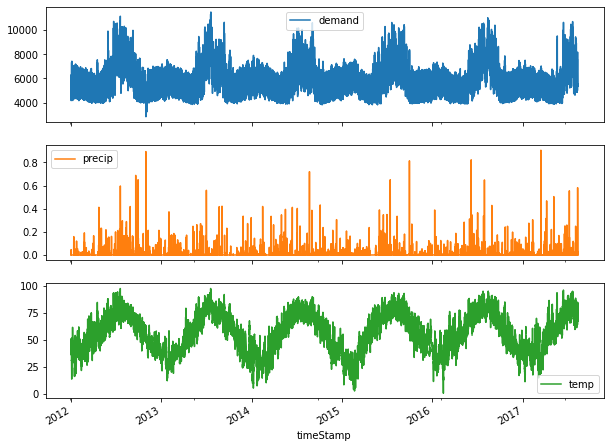

In [7]:
ny_df=df.set_index('timeStamp')
ny_df.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f637897f210>,
      dtype=object)

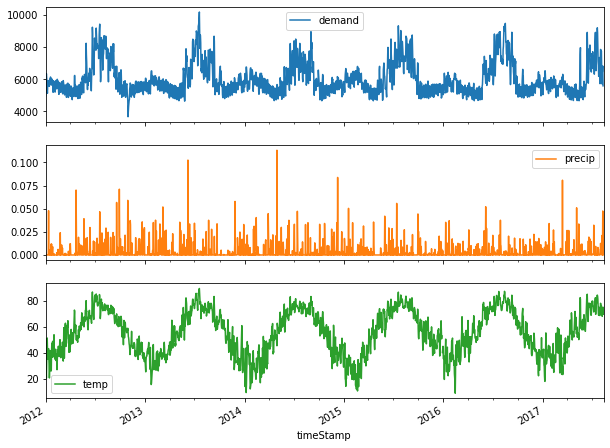

In [8]:
ny_df_daily=ny_df.resample('D').mean()
ny_df.resample('D').mean().plot(subplots=True)

# Facebook Prophet


Prophet Paper - https://peerj.com/preprints/3190/

y(t)= g(t) + s(t) + h(t) + εt<br>
y(t) -> Target variable<br>
g(t) -> Trend function, can be a piece wise linear regression model<br>
s(t) -> Seasonaity, By default its additive seasonality - when data is stationary<br>
h(t) -> Holiday data, spike up, dip etc<br>
εt -> Residual

# Uni variate modelling


In [9]:
from fbprophet import Prophet

In [10]:
ny_df_final=ny_df_daily.reset_index()[['timeStamp','demand']].rename({'timeStamp':'ds','demand':'y'}, axis='columns')
ny_df_final
# Prop[het handles the null value, but ideally we should impute the null values according to our business understanding

,ds,y
0,2012-01-01,4954.833333
1,2012-01-02,5302.954167
2,2012-01-03,6095.512500
3,2012-01-04,6336.266667
4,2012-01-05,6130.245833
...,...,...
2046,2017-08-08,6471.626042
2047,2017-08-09,6811.112167
2048,2017-08-10,5582.297000
2049,2017-08-11,NaN


In [11]:
train=ny_df_final[(ny_df_final['ds'] >= '2012-01-01') & (ny_df_final['ds'] <= '2017-04-30')]
test=ny_df_final[(ny_df_final['ds'] > '2017-04-30')]
train.shape

(1947, 2)

In [12]:
print(test.shape)
test

(104, 2)


,ds,y
1947,2017-05-01,5417.231583
1948,2017-05-02,5697.950042
1949,2017-05-03,5354.628500
1950,2017-05-04,5235.704833
1951,2017-05-05,5358.639500
...,...,...
2046,2017-08-08,6471.626042
2047,2017-08-09,6811.112167
2048,2017-08-10,5582.297000
2049,2017-08-11,NaN


In [13]:
# with confidence interval of 95%, by default - 80%
# There is an yearly seasonality - it can also find this on its own
m = Prophet(interval_width=0.95,yearly_seasonality=True)
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
# Model learned parameters
m.params

{'beta': array([[-0.03474564, -0.07051982,  0.05760445,  0.04706222, -0.01404777,
         -0.00499591, -0.00387932, -0.00073284,  0.00241073, -0.00756147,
          0.00404936,  0.00483016, -0.00789882, -0.00470511,  0.00701484,
         -0.00268429, -0.00128001,  0.00170179,  0.00035188, -0.0002186 ,
         -0.02824661,  0.02385118,  0.0206227 ,  0.00054777, -0.00494972,
         -0.00501049]]),
 'delta': array([[-3.50360674e-09, -1.32489168e-02, -7.74174578e-02,
          2.56670913e-08,  8.81258464e-08, -1.46805043e-08,
          1.70635442e-08, -2.64450633e-08, -5.82121639e-08,
          5.89599724e-08, -5.16647027e-02, -5.73312969e-02,
         -5.10303343e-05,  3.64173165e-08,  2.05843529e-01,
          5.29272199e-02, -1.73045352e-07, -8.36841050e-02,
         -7.56589140e-02,  3.12992747e-08, -2.32275699e-08,
          1.07689546e-08,  2.03120136e-02,  2.96291061e-03,
          2.74957150e-08]]),
 'k': array([[0.08260908]]),
 'm': array([[0.5937986]]),
 'sigma_obs': array([[

## Forecasting

In [15]:
# Create dates for next 104 periods (days according to our current train data)
future = m.make_future_dataframe(periods=104)
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [16]:
# along with the next 104 periods it will also have a place holder for train period
future

,ds
0,2012-01-01
1,2012-01-02
2,2012-01-03
3,2012-01-04
4,2012-01-05
...,...
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11


In [17]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7592.967315,6696.432854,8469.539788
2047,2017-08-09,7582.126815,6691.689948,8556.303075
2048,2017-08-10,7536.891048,6659.674928,8436.310565
2049,2017-08-11,7492.155420,6650.797653,8328.543367
2050,2017-08-12,6917.407396,5995.547959,7853.970626


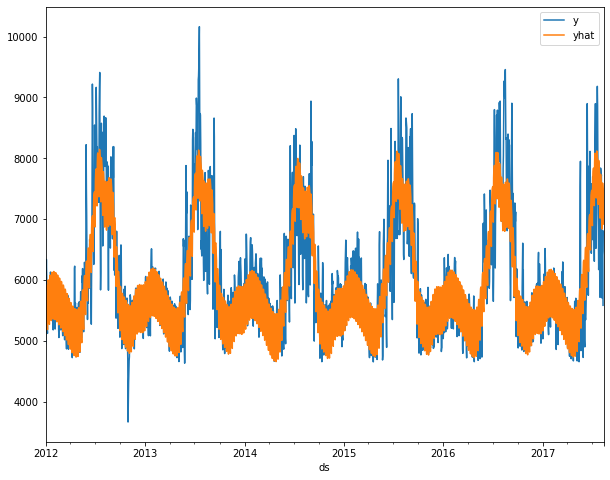

In [18]:
pd.concat([ny_df_final.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

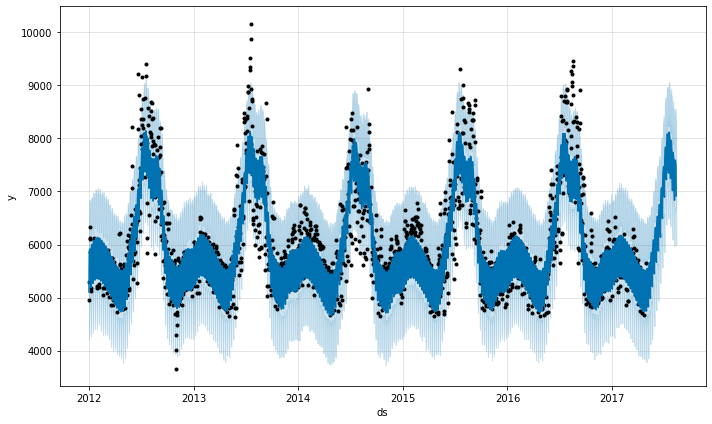

In [19]:
# Light blue - 95% confidence interval
# dark blue - prediction
# black points - actual values
fig1 = m.plot(forecast)

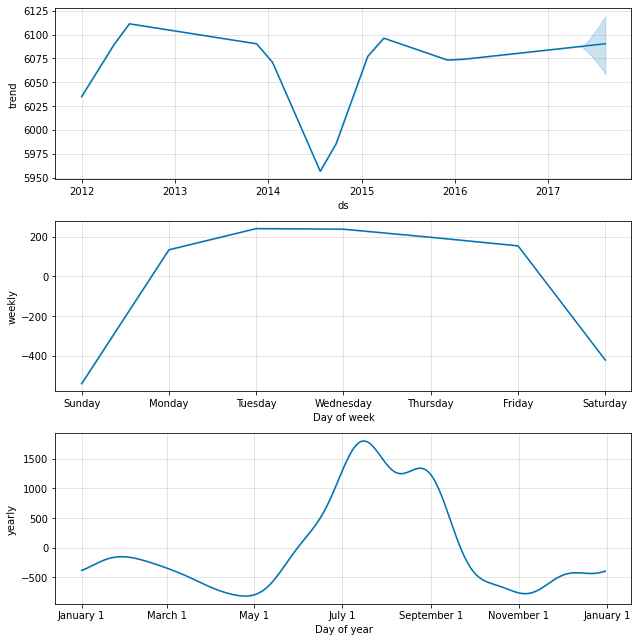

In [20]:
# Components of timeseries recognized by FB Prophet
fig2 = m.plot_components(forecast)

## Changing points of trend
Thing to notice here is that trend modelling by default is done on piece wise linear regression... so  any change in those trend slope is known as changing points.
* By default prophet plot the change points on 80% of the data.
* We can increase this to 90%
* Maximum it does 25 change points.
* If we know our business very well, we can add our custom change points as well.

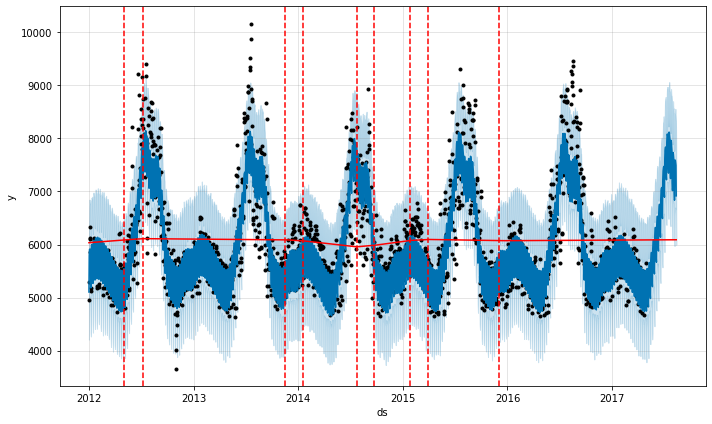

In [21]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [22]:
# Deltas describe that if there was a change in trend, how much does it changed
deltas = m.params['delta'].mean(0)
deltas

array([-3.50360674e-09, -1.32489168e-02, -7.74174578e-02,  2.56670913e-08,
        8.81258464e-08, -1.46805043e-08,  1.70635442e-08, -2.64450633e-08,
       -5.82121639e-08,  5.89599724e-08, -5.16647027e-02, -5.73312969e-02,
       -5.10303343e-05,  3.64173165e-08,  2.05843529e-01,  5.29272199e-02,
       -1.73045352e-07, -8.36841050e-02, -7.56589140e-02,  3.12992747e-08,
       -2.32275699e-08,  1.07689546e-08,  2.03120136e-02,  2.96291061e-03,
        2.74957150e-08])

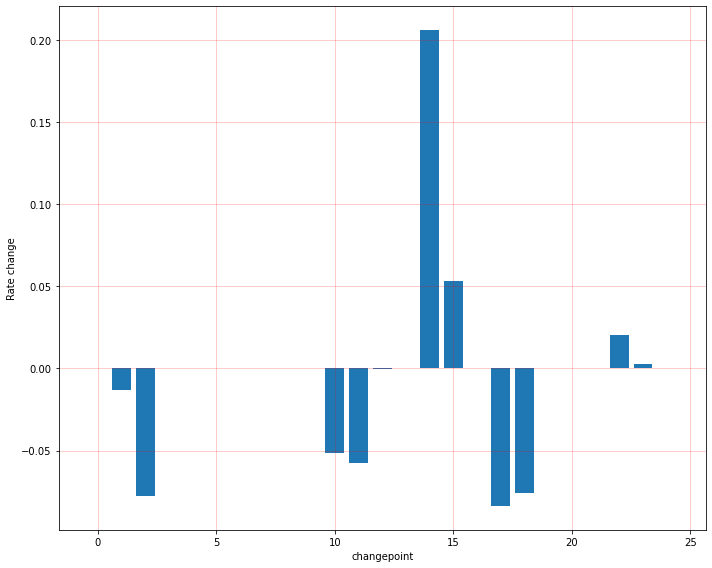

In [23]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='red', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('changepoint')
fig.tight_layout()

In [24]:
# When was the change in trend
m.changepoints

62     2012-03-03
124    2012-05-04
187    2012-07-06
249    2012-09-06
311    2012-11-07
373    2013-01-08
436    2013-03-12
498    2013-05-13
560    2013-07-14
622    2013-09-14
685    2013-11-16
747    2014-01-17
809    2014-03-20
871    2014-05-21
934    2014-07-23
996    2014-09-23
1058   2014-11-24
1120   2015-01-25
1183   2015-03-29
1245   2015-05-30
1307   2015-07-31
1369   2015-10-01
1432   2015-12-03
1494   2016-02-03
1556   2016-04-05
Name: ds, dtype: datetime64[ns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


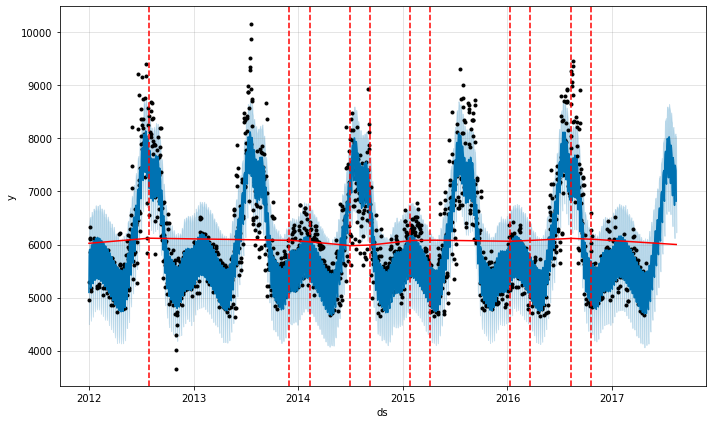

In [25]:
# changing my training data percentage for change point calculation
pro_change= Prophet(changepoint_range = 0.9, yearly_seasonality=True)
forecast = pro_change.fit(train).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast) 

In [26]:
# Plotly plot from prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

## Evaluation

In [27]:
from fbprophet.diagnostics import cross_validation
cv_results = cross_validation( model = m, initial = '731 days', horizon = '365 days', period='180 days')
# We are taking 731 days of data
# period defines the training period
# On total of 731 days of data, 1. train on 180 days and predict on 365 days, 2. Train on 360 days and then predict on next 365 days

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-11 00:00:00 and 2016-04-30 00:00:00


In [28]:
cv_results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-12,5730.022372,4842.780029,6577.339259,6082.141667,2014-05-11
1,2014-05-13,5850.202057,5051.853209,6658.128941,5832.158333,2014-05-11
2,2014-05-14,5929.290989,5103.474779,6754.571767,5527.975000,2014-05-11
3,2014-05-15,5988.903089,5184.294250,6743.917131,5757.691667,2014-05-11
4,2014-05-16,6010.143366,5232.231129,6830.850548,5870.904167,2014-05-11
...,...,...,...,...,...,...
1820,2017-04-26,5217.781382,4278.705377,6203.593975,5342.687591,2016-04-30
1821,2017-04-27,5170.452429,4213.169420,6048.291025,5445.442917,2016-04-30
1822,2017-04-28,5118.829023,4213.191289,5979.806125,5648.995917,2016-04-30
1823,2017-04-29,4543.320326,3604.464750,5466.580167,5467.143125,2016-04-30


In [29]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,270886.753879,520.467822,426.974964,0.075290,0.068289,0.873626
1,38 days,287208.262373,535.918149,442.542050,0.077256,0.070168,0.862637
2,39 days,290944.564490,539.392774,449.397102,0.078225,0.070636,0.862637
3,40 days,294930.447420,543.074992,454.865006,0.079075,0.071477,0.862637
4,41 days,298822.830296,546.646897,459.769426,0.079986,0.072350,0.857143
...,...,...,...,...,...,...,...
324,361 days,227959.035305,477.450558,416.191703,0.077490,0.077628,0.986813
325,362 days,215198.847468,463.895298,407.082306,0.076165,0.077628,0.992308
326,363 days,203009.546674,450.565807,400.118196,0.075250,0.075972,0.997802
327,364 days,205720.573924,453.564300,402.003920,0.075617,0.075972,0.989011


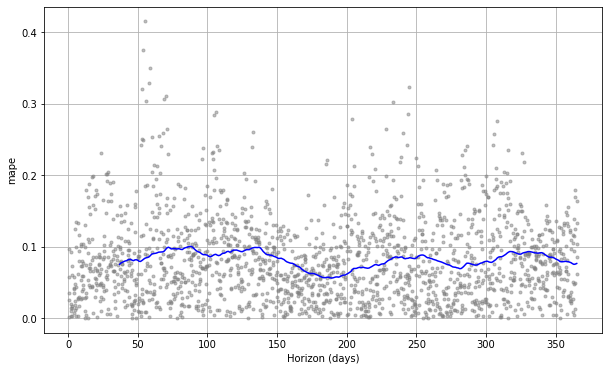

In [30]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric='mape')
# around 0.1

# Multi variate modelling


In [31]:
ny_df_final=ny_df_daily.reset_index()[['timeStamp','demand','temp']].rename({'timeStamp':'ds','demand':'y','temp':'temp'}, axis='columns')
ny_df_final

,ds,y,temp
0,2012-01-01,4954.833333,46.510000
1,2012-01-02,5302.954167,40.496667
2,2012-01-03,6095.512500,26.672500
3,2012-01-04,6336.266667,20.585000
4,2012-01-05,6130.245833,33.577500
...,...,...,...
2046,2017-08-08,6471.626042,71.039167
2047,2017-08-09,6811.112167,73.852500
2048,2017-08-10,5582.297000,75.217500
2049,2017-08-11,NaN,72.767917


In [32]:
# Prophet only handles missing values on target column
ny_df_final.query('temp != temp')

,ds,y,temp
1457,2015-12-28,5510.776333,NaN


In [33]:
ny_df_final['temp']=ny_df_final['temp'].fillna(method='ffill')
ny_df_final.query('temp != temp')

,ds,y,temp


In [34]:
ny_df_final['month']=ny_df_final['ds'].dt.month
ny_df_final.head()

,ds,y,temp,month
0,2012-01-01,4954.833333,46.510000,1
1,2012-01-02,5302.954167,40.496667,1
2,2012-01-03,6095.512500,26.672500,1
3,2012-01-04,6336.266667,20.585000,1
4,2012-01-05,6130.245833,33.577500,1


In [35]:
fig = px.line(ny_df_final, x='ds', y='y', hover_data=['temp','month'], title='NYC Energy Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()
# If we look at the outliers, which our uni variate model didn't detect, we can see that those days have a high temprature

In [36]:
ny_df_final[['month','temp']].groupby('month').agg({'temp':{'max','min','mean'}})

temp                      
             min       mean        max
month                                 
1       9.507917  33.432140  55.420455
2       9.015000  34.517758  59.360000
3      20.291667  41.419884  67.878333
4      33.045833  52.600204  72.992083
5      48.090833  62.543994  82.576250
6      52.405833  71.334418  86.916667
7      66.417083  77.595627  89.606667
8      68.042083  75.525947  87.426250
9      57.274583  69.550306  84.448750
10     42.106250  58.642895  74.277500
11     27.172500  47.225638  67.606250
12     22.429583  41.520068  64.735000

In [37]:
ny_df_final[['y','temp']].corr()

,y,temp
y,1.000000,0.560888
temp,0.560888,1.000000


In [38]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

result = adfuller(ny_df_final['temp'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critial Values: {result[4]}')

if result[1] > 0.05 :
  print('Series is not Stationary')
else:
  print('Series is Stationary')
# Although series is not stationary and granger causality only works on stationary data, we will go ahead and check
# because p value is around 10%

Test Statistics: -2.556742718983297
p-value: 0.10227123953389744
Critial Values: {'1%': -3.4335627358346366, '5%': -2.862959228246899, '10%': -2.567525534009848}
Series is not Stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [40]:
ny_df_final_nonull = ny_df_final.copy()
ny_df_final_nonull['y']=ny_df_final_nonull['y'].fillna(method='ffill')
max_lags=5
results=grangercausalitytests(ny_df_final_nonull[['y','temp']], max_lags, verbose=False)
p_values=[round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
print('P Values per lag - '+str(p_values))
# No causality found
# temp directly is not usefull

P Values per lag - [0.0, 0.0, 0.0, 0.0, 0.0]


In [41]:
# It was very clear from uni variate modelling that model was not picking up the sudden peak in demand
# sudden peak in demand is due to high temp
# lets pass this feature instead of direct temprature
def summer_temp(temp):
  if temp > 80:
    return 1
  else:
    return 0

In [42]:
ny_df_final['summer_temp']=ny_df_final['temp'].apply(summer_temp)
# month bin - 0,1,2 - 4 months per bin
ny_df_final['month_bins']=pd.cut(ny_df_final['month'],bins=3, labels=False)
ny_df_final

,ds,y,temp,month,summer_temp,month_bins
0,2012-01-01,4954.833333,46.510000,1,0,0
1,2012-01-02,5302.954167,40.496667,1,0,0
2,2012-01-03,6095.512500,26.672500,1,0,0
3,2012-01-04,6336.266667,20.585000,1,0,0
4,2012-01-05,6130.245833,33.577500,1,0,0
...,...,...,...,...,...,...
2046,2017-08-08,6471.626042,71.039167,8,0,1
2047,2017-08-09,6811.112167,73.852500,8,0,1
2048,2017-08-10,5582.297000,75.217500,8,0,1
2049,2017-08-11,NaN,72.767917,8,0,1


In [43]:
train=ny_df_final[(ny_df_final['ds'] >= '2012-01-01') & (ny_df_final['ds'] <= '2017-04-30')]
test=ny_df_final[(ny_df_final['ds'] > '2017-04-30')]

In [44]:
print(train.shape)
print(test.shape)

(1947, 6)
(104, 6)


In [45]:
# Model it for 95% confidence interval
m = Prophet(interval_width=0.95,yearly_seasonality=True)

In [46]:
# Prophet only takes ds and y
# we will have to add columns as additional regressor
# standardize = False - dont standardize this data
# additive mode is default
# refer decompositions to figure out the difference
m.add_regressor('summer_temp',standardize=False)
m.add_regressor('month_bins',standardize=False,mode='multiplicative')

In [47]:
m.fit(train)
m.params

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'beta': array([[-0.03556816, -0.0591133 ,  0.04943303,  0.04017231, -0.00950298,
         -0.00176671, -0.00780182, -0.00252818,  0.00341513, -0.0058558 ,
          0.00140882,  0.00306431, -0.00526155, -0.0038083 ,  0.00336648,
         -0.00276373,  0.00071623,  0.00143949, -0.00131436, -0.00031936,
         -0.02719643,  0.02415033,  0.02027408,  0.00152641, -0.00497218,
         -0.00518714,  0.13390651, -0.0092762 ]]),
 'delta': array([[ 9.53087024e-09, -2.65217570e-07, -1.89524134e-01,
         -6.20506518e-07, -5.59486392e-08,  1.57995098e-02,
          7.36635005e-03,  1.94277335e-03,  2.33799803e-05,
          8.95579169e-06, -8.93996393e-06, -3.87636824e-02,
         -8.77282339e-06,  1.04880753e-07,  1.45765077e-01,
          2.06677871e-04, -4.35138150e-08, -1.04416779e-01,
         -4.70282613e-02, -1.81056592e-07, -1.85095509e-07,
          7.83844354e-08,  4.03125700e-02,  3.15853497e-02,
         -1.69335986e-07]]),
 'k': array([[0.15202679]]),
 'm': array([[0.58858642

In [48]:
future = m.make_future_dataframe(periods=104)
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [49]:
future['summer_temp'] = ny_df_final['summer_temp']
future['month_bins'] = ny_df_final['month_bins']
future

,ds,summer_temp,month_bins
0,2012-01-01,0,0
1,2012-01-02,0,0
2,2012-01-03,0,0
3,2012-01-04,0,0
4,2012-01-05,0,0
...,...,...,...
2046,2017-08-08,0,1
2047,2017-08-09,0,1
2048,2017-08-10,0,1
2049,2017-08-11,0,1


In [50]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7386.238637,6633.021879,8132.462834
2047,2017-08-09,7397.023923,6657.032195,8213.018001
2048,2017-08-10,7367.319006,6595.186134,8141.942543
2049,2017-08-11,7317.115202,6570.483825,8084.855783
2050,2017-08-12,6736.248010,5969.478643,7504.292811


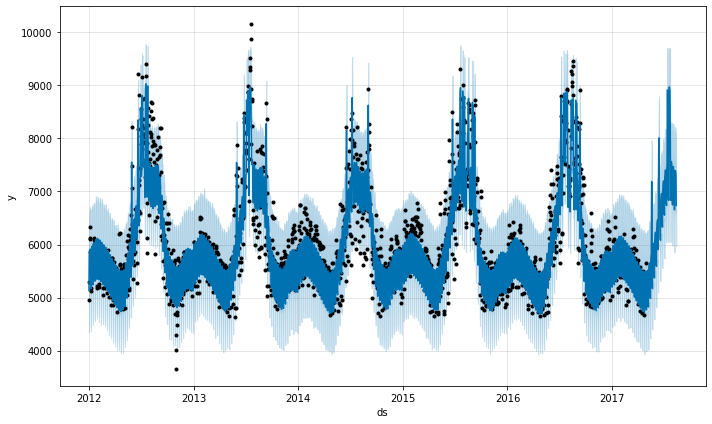

In [51]:
fig1 = m.plot(forecast)

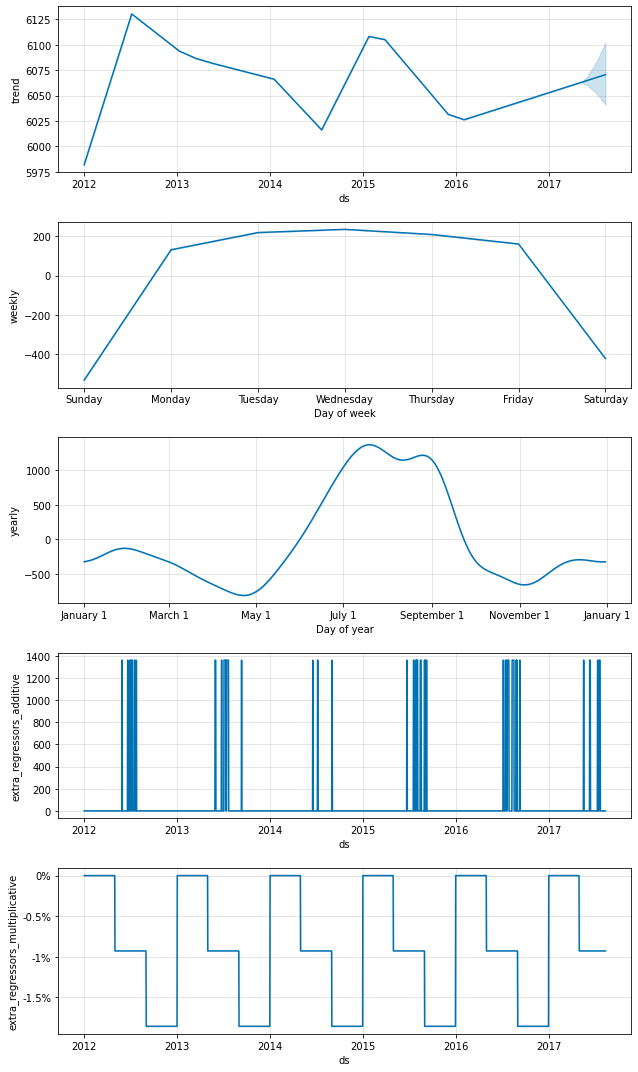

In [52]:
fig2 = m.plot_components(forecast)

In [53]:
from fbprophet.diagnostics import cross_validation,  performance_metrics
cv_results = cross_validation( model = m, initial = '731 days', horizon = '365 days')
df_p = performance_metrics(cv_results)
df_p

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,207091.351050,455.072907,356.656966,0.063278,0.051366,0.906593
1,37 days 00:00:00,213175.140345,461.708935,363.589373,0.064444,0.053034,0.895604
2,37 days 12:00:00,214543.920550,463.188861,365.992292,0.064850,0.054296,0.895604
3,38 days 00:00:00,218546.723911,467.489812,369.840365,0.065223,0.054497,0.890110
4,38 days 12:00:00,220907.695673,470.008187,373.776087,0.065846,0.054716,0.890110
...,...,...,...,...,...,...,...
653,363 days 00:00:00,163520.569582,404.376767,343.378295,0.062870,0.062709,0.978022
654,363 days 12:00:00,164383.649077,405.442535,343.391670,0.062873,0.062709,0.978022
655,364 days 00:00:00,167372.805641,409.112216,345.915222,0.063548,0.063483,0.972527
656,364 days 12:00:00,167125.921852,408.810374,344.978922,0.063401,0.062869,0.972527


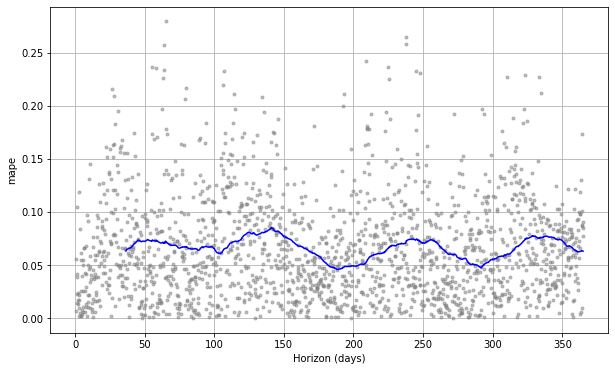

In [54]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric='mape')
# More towards 0.05